This notebook shows how to use yaglm's `opt` module that is built around FISTA. We start with a minimial example illustrating the two parts of the `opt` module 1) constructing the objective function with smooth/non-smooth function objects and 2) using the FISTA algorithm. We then dig into several of the bells and whistles that come with the opt module.

Recall that FISTA works for optimization problems that look like 

$$ \text{minimize}_{\theta} f(\theta) + p(\theta)$$

where $f(\cdot)$ is a smooth function and $p(\cdot)$ is a non-smooth function that has an easy to evaluate proximal operator.


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from yaglm.toy_data import sample_sparse_lin_reg

In [2]:
# toy linear regression data
n_features = 10
X, y, model_info = sample_sparse_lin_reg(n_samples=100,
                                         n_features=n_features,
                                         beta_type=2, random_state=1)

# 1) Basic illustration of the opt module

### Setup loss and penalty objects

In [3]:
from yaglm.opt.glm_loss.linear_regression import LinReg
from yaglm.opt.penalty.convex import Lasso

In [4]:
smooth_func = LinReg(X=X, y=y, fit_intercept=False)

pen_val = 1 # Lasso penalty value
non_smooth_func = Lasso(pen_val=pen_val)

In [5]:
coef = np.zeros(n_features)
print('Least squares loss', smooth_func.eval(coef))
print('Lasso loss value', non_smooth_func.eval(coef))
print('Least squares gradient', smooth_func.grad(coef))
print('Lasso proximal operator', non_smooth_func.prox(coef, step=1)) # note the proximal operator has a step size!
print("Least squares loss Lipchitz constant", smooth_func.grad_lip)


Least squares loss 5.36060259052983
Lasso loss value 0.0
Least squares gradient [-1.78367109 -1.98913908 -1.81382994 -2.09901075 -1.69731402 -0.56152831
  0.04852157  0.67414728  0.20866805 -0.50194201]
Lasso proximal operator [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Least squares loss Lipchitz constant 2.04553754412543


### Run FISTA 

In [6]:
from yaglm.opt.algo.fista import solve_fista

In [7]:
soln, opt_info = solve_fista(smooth_func=smooth_func, non_smooth_func=non_smooth_func,
                             init_val=np.zeros(n_features), # must specify initial value
                             
                             step='lip', # get step size from smooth loss Lipchitz constant
                             accel=True, # use FISTA acceleration
                             restart=True, # FISTA with restarts
                             
                             stop_crit='x_max', tol=1e-5, # stop when no x coordinate has moved more than 1e-5
                             max_iter=200,
                             
                             tracking_level=1, # how much data to track
                            )

print(soln)
opt_info # we the optimization history e.g. number of iterations, runtime, etc

[0.33409507 0.64610743 0.31373186 0.71872811 0.30653239 0.
 0.         0.         0.         0.        ]


{'runtime': 0.0034170150756835938,
 'history': {'objective': [5.36060259052983,
   4.300932771143718,
   4.287150706473769,
   4.284024393926995,
   4.282167667803977,
   4.281194414885658,
   4.280781037405891,
   4.28067153412271,
   4.280682407630497,
   4.280711551008791,
   4.280697951360532,
   4.280688524313096,
   4.280680356331714,
   4.280674275148842,
   4.280670371722292,
   4.280668260046928,
   4.28066736073723,
   4.280667123461151,
   4.280667148475202,
   4.280667212770655,
   4.28066718340316,
   4.280667162997613,
   4.280667145288062,
   4.280667132084909,
   4.280667123601089,
   4.2806671190081715,
   4.280667117051353,
   4.280667116535066,
   4.280667116589669,
   4.280667116729722],
  'restarts': [8, 9, 18, 19, 28]},
 'stop_crit': 'x_max',
 'stop': True,
 'iter': 28}

### Compare against sklearn solution

In [8]:
from sklearn.linear_model import Lasso as sk_Lasso
sk_lasso = sk_Lasso(alpha=pen_val, fit_intercept=False)
sk_lasso.fit(X, y)
print('Max norm difference between sklearn and our FISTA:', abs(sk_lasso.coef_ - soln).max())

Max norm difference between sklearn and our FISTA: 5.9537272565135524e-05


### Including an intercept

To include an intercept that isn't penalized we need to
- tell the loss function we have an intercept
- wrap the penalty in a WithIntercept() object
- concatenate the intercept/coefficient initializers

In [9]:
from yaglm.opt.penalty.utils import WithIntercept

In [10]:
# specify initercept in LS loss function init
smooth_func = LinReg(X=X, y=y, fit_intercept=True)

# wrap the lasso in a WithIntercept() object to ensure the intercept is not penalized
non_smooth_func = WithIntercept(Lasso(pen_val=pen_val))

# the optimization variable is concatenation of the intercept (first coordinate) and the coefficient
coef_init = np.zeros(n_features)
intercept_init = 0
init_val = np.concatenate([[intercept_init], coef_init])

# Solve with FISTA
soln_with_inter, opt_info = solve_fista(smooth_func=smooth_func, non_smooth_func=non_smooth_func,
                                        init_val=init_val)
# pull out coef/intecept solutions
intercept_soln = soln_with_inter[0]
coef_soln = soln_with_inter[1:]

# Compare to sklearn
sk_lasso = sk_Lasso(alpha=pen_val, fit_intercept=True).fit(X, y)
print('Coefficient max norm difference between sklearn and our FISTA:', abs(sk_lasso.coef_ - coef_soln).max())
print('Intercept difference between sklearn and our FISTA:', abs(sk_lasso.intercept_ - intercept_soln).max())

Coefficient max norm difference between sklearn and our FISTA: 5.467406813697284e-05
Intercept difference between sklearn and our FISTA: 2.6193384678185883e-06


# 2) Composite objective functions

### penalty = generalized ridge + lasso 

In [11]:
from yaglm.opt.base import Sum
from yaglm.opt.penalty.convex import GeneralizedRidge
from yaglm.trend_filtering import get_tf_mat

In [12]:
# setup a generalized ridge penalty using a first order difference trend filtering matrix
trend_filter_mat = get_tf_mat(d=n_features, k=1)
ridge_penalty_func = GeneralizedRidge(pen_val=1, mat=trend_filter_mat)
ridge_penalty_func = WithIntercept(ridge_penalty_func)  # handle intercept!

# Smooth loss is sum of least squares loss and generalized ridge
LS_loss = LinReg(X=X, y=y, fit_intercept=True)
smooth_func = Sum([LS_loss, ridge_penalty_func])

# Non smooth is still Lasso
non_smooth_func = WithIntercept(Lasso(pen_val=pen_val))

# Solve with FISTA
soln, opt_info = solve_fista(smooth_func=smooth_func, non_smooth_func=non_smooth_func,
                             init_val=np.concatenate([[0], np.zeros(n_features)]))

### block separable penalties 

E.g. put one penalty on one subset of features and another penalty on another subset of features

In [13]:
from yaglm.opt.BlockSeparable import BlockSeparable
from yaglm.opt.base import Zero

In [14]:
# No penalty on first 5 features, Lasso penalty on last 5 features
non_smooth_func = BlockSeparable(funcs=[Zero(), Lasso(pen_val=10)],
                                 groups=[range(5), range(5, 10)])
non_smooth_func = WithIntercept(non_smooth_func)

soln, opt_info = solve_fista(smooth_func=LinReg(X=X, y=y, fit_intercept=True),
                             non_smooth_func=non_smooth_func,
                             init_val=np.concatenate([[0], np.zeros(n_features)]))

soln # notice the last 5 features are zeroed out!

array([0.04647322, 0.99640954, 0.99477212, 1.09196743, 0.98830115,
       1.07259316, 0.        , 0.        , 0.        , 0.        ,
       0.        ])

# 4) Other loss functions

In [15]:
from yaglm.opt.glm_loss.huber_regression import HuberReg
from yaglm.opt.glm_loss.logistic_regression import LogReg
from yaglm.opt.glm_loss.poisson_regression import PoissonReg

Text(0.5, 1.0, 'Poisson loss, FISTA with backtracking step size')

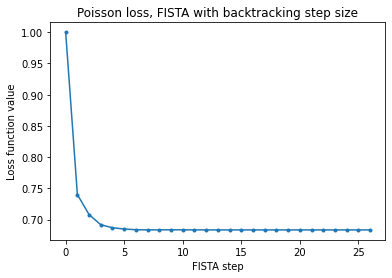

In [16]:
# huber loss
soln, opt_info = solve_fista(smooth_func=HuberReg(X=X, y=y, fit_intercept=False, knot=1.35),  
                             init_val=np.zeros(n_features),
                            )


# logistic regression
y_binary = (y > 0).astype(int) # logistic regresssion expects y to be binarized
soln, opt_info = solve_fista(smooth_func=LogReg(X=X, y=y_binary, fit_intercept=False), 
                             init_val=np.zeros(n_features),
                            )



# Poisson regression
# The Poisson loss is not Lipchtiz differentiable so we can't use setp='lip'
# so we instead do a backtracking line search for the step seize
y_pos = abs(y) # Poisson expects y to be potitive
soln, opt_info = solve_fista(smooth_func=PoissonReg(X=X, y=y_pos, fit_intercept=False), 
                             init_val=np.zeros(n_features),
                             
                             backtracking=True, # enable backgracking line search
                             step=1, # initial step size for backtracking line search
                             
                             tracking_level=1)


plt.plot(opt_info['history']['objective'], marker='.')
plt.xlabel("FISTA step")
plt.ylabel("Loss function value")
plt.title("Poisson loss, FISTA with backtracking step size")

# 5) Other penalties

In [17]:
from yaglm.opt.penalty.convex import GroupElasticNet
from yaglm.opt.penalty.nonconvex import SCAD

In [18]:
# SCAD penalty
scad_penalty = SCAD(pen_val=1, a=3.7)
soln, opt_info = solve_fista(smooth_func=LinReg(X=X, y=y, fit_intercept=False),  
                             non_smooth_func=scad_penalty,
                             init_val=np.zeros(n_features),
                            )

# Group ElasticNet
group_enet = GroupElasticNet(groups=[range(5), range(5, 10)], pen_val=1, mix_val=0.5)
soln, opt_info = solve_fista(smooth_func=LinReg(X=X, y=y, fit_intercept=False),  
                             non_smooth_func=group_enet,
                             init_val=np.zeros(n_features),
                            )


# 6) Constraints

In [19]:
from yaglm.opt.constraint.convex import Positive, Simplex

In [20]:
# Positive orthan constraint
soln, opt_info = solve_fista(smooth_func=LinReg(X=X, y=y, fit_intercept=False),  
                             non_smooth_func=Positive(),
                             init_val=np.zeros(n_features),
                            )

soln # all entries are positive

array([1.00207976, 0.99074204, 1.09582945, 0.97885717, 1.07405845,
       0.        , 0.        , 0.        , 0.03341862, 0.        ])

In [21]:
# Unit simplex constraint
soln, opt_info = solve_fista(smooth_func=LinReg(X=X, y=y, fit_intercept=False),  
                             non_smooth_func=Simplex(mult=1), # unit simplex
                             init_val=np.zeros(n_features),
                            )

soln.sum() # all entries are positive and sum to 1

0.9999999999999996

### Notes

- The `opt` module is very general e.g. it useful beyond generalized linear models and the FISTA algorithm
- It is designed primarily with generality in mind; other state of the art solvers can give faster results for specific problems (e.g. linear regression + lasso penalty). Optimization benchmarks are forthcoming, but in my informal experience it can be comparable or a bit slower than sklearn for the cython solvers you can find in sklearn.
- There are probably straightforward optimizations we can make to the `opt` module in the future! Contributions are very welcome!